Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/upgrad/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/upgrad/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size,
    color_mode='rgb'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        seed=123,
        validation_split=0.2,
        subset='validation',
        image_size=(img_height,img_width),
        batch_size=batch_size,
        color_mode='rgb'
      )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

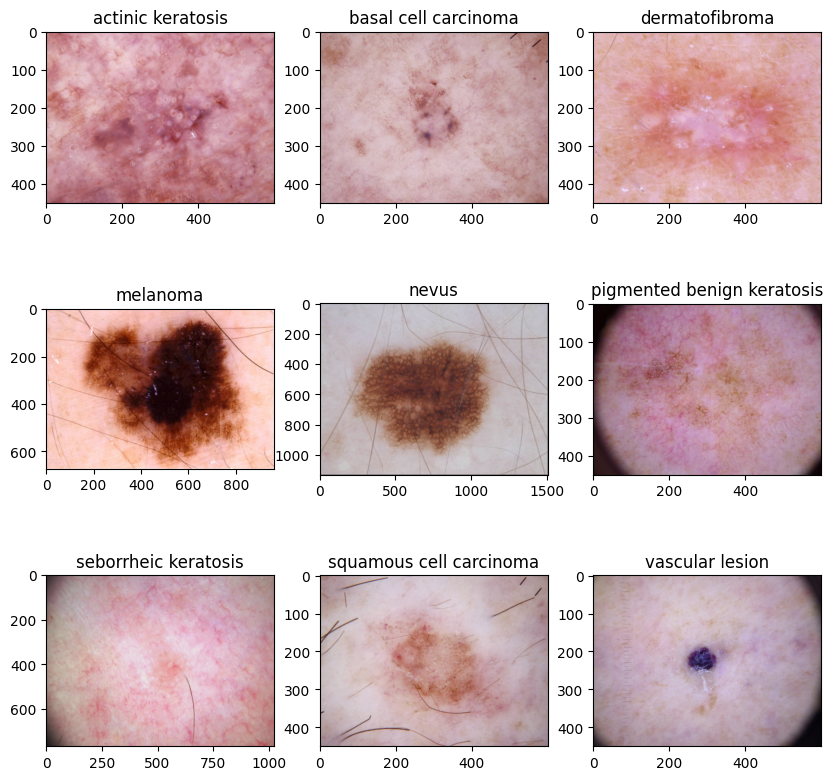

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(len(class_names)):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 421s 2s/step - loss: 2.0862 - accuracy: 0.2400 - val_loss: 1.7218 - val_accuracy: 0.4340
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6403 - accuracy: 0.4191 - val_loss: 1.4867 - val_accuracy: 0.5123
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5160 - accuracy: 0.4660 - val_loss: 1.5188 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.3520 - accuracy: 0.5184 - val_loss: 1.4454 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.2640 - accuracy: 0.5480 - val_loss: 1.3248 - val_accuracy: 0.5638
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.2582 - accuracy: 0.5558 - val_loss: 1.3687 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.1780 - accuracy: 0.5859 - val_loss: 1.3908 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing training results

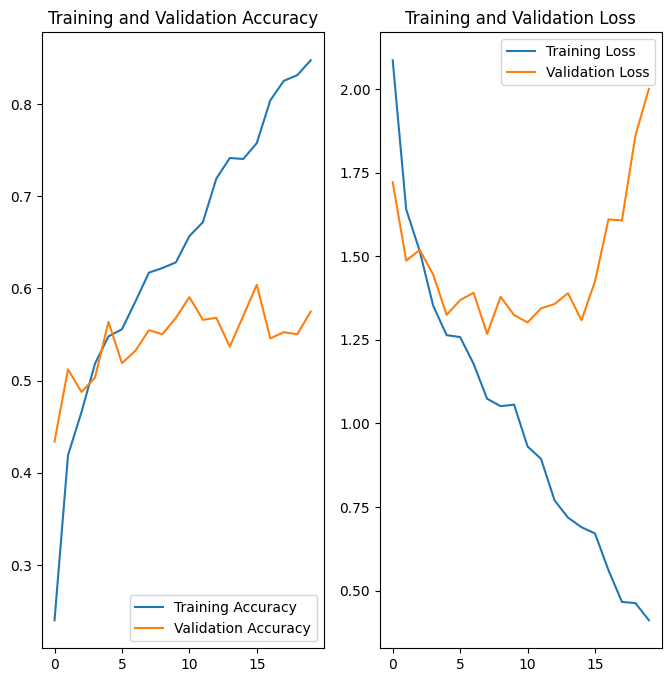

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Loss: ",loss)
print("Validation Accuracy: ",accuracy_v)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 13ms/step - loss: 2.0007 - accuracy: 0.5749
Accuracy:  0.91015625
Loss:  0.22937548160552979
Validation Accuracy:  0.5749440789222717
Validation Loss 2.000702381134033


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

> Add blockquote



### Write your findings here

#### Observations:

1.   Training accuracy is pretty high but training loss is very low.
2.   Validation accuracy is very low but validation loss is very high.
3.   We can see that training accuracy increases with epochs but validation accuracy does not improve beyond 55%-58%.
4.   With the increase in epochs, training accuracy falls, but the validation accuracy first shows a downward trend but then reverses and starts increasing.
5.   High training accuracy and low validation accuracy indicates Overfitting.
6.   Low training loss and high validation loss too confirms Overfitting.









In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1,0.1),
])


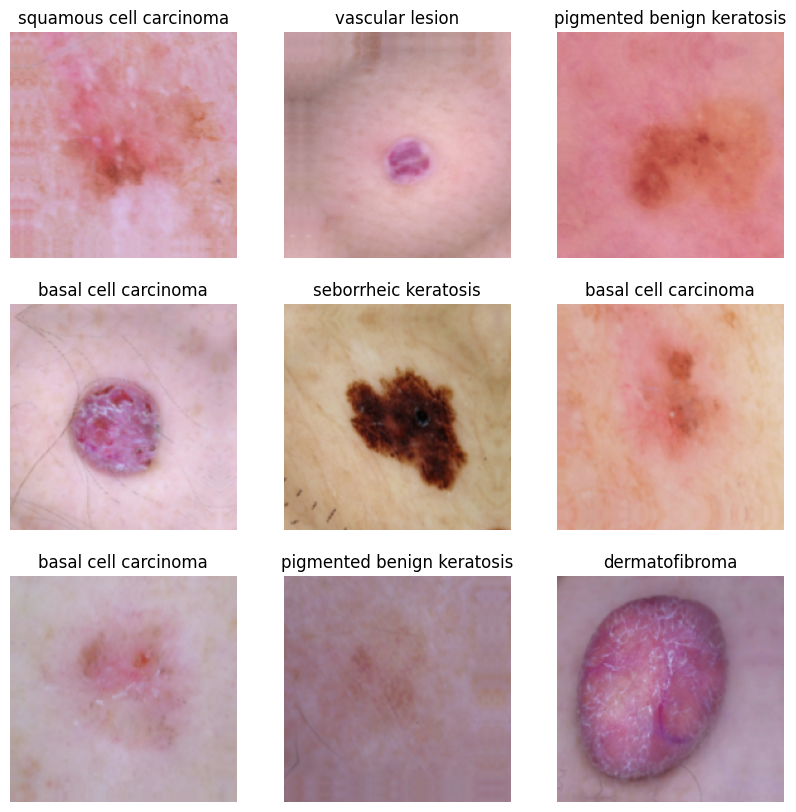

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))



### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 70ms/step - loss: 2.2009 - accuracy: 0.2204 - val_loss: 1.9088 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8873 - accuracy: 0.3013 - val_loss: 1.7556 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 1.6931 - accuracy: 0.3901 - val_loss: 1.5991 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6714 - accuracy: 0.4180 - val_loss: 1.5173 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.5663 - accuracy: 0.4408 - val_loss: 1.5019 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.5342 - accuracy: 0.4732 - val_loss: 1.4080 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4884 - accuracy: 0.4833 - val_loss: 1.4486 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing the results

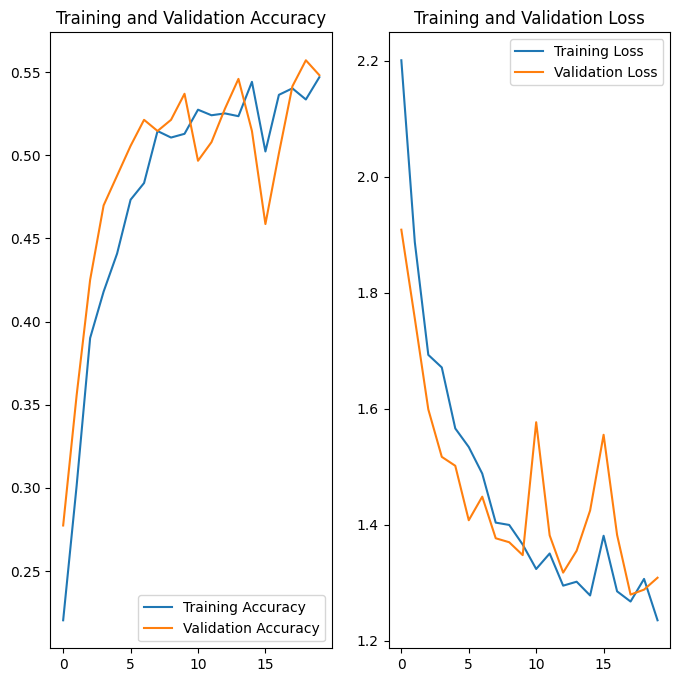

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [26]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Loss: ",loss)
print("Validation Accuracy: ",accuracy_v)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 1.3089 - accuracy: 0.5481
Accuracy:  0.55859375
Loss:  1.206344485282898
Validation Accuracy:  0.5480984449386597
Validation Loss 1.3089274168014526


#### Observations:

1.   Training accuracy and validation accuracy are in sync now.
2.   Training loss and validation loss are nearly equal.
3.   Although, the accuracy has come down, yet, the overfitting issue has been addressed to a great extent.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

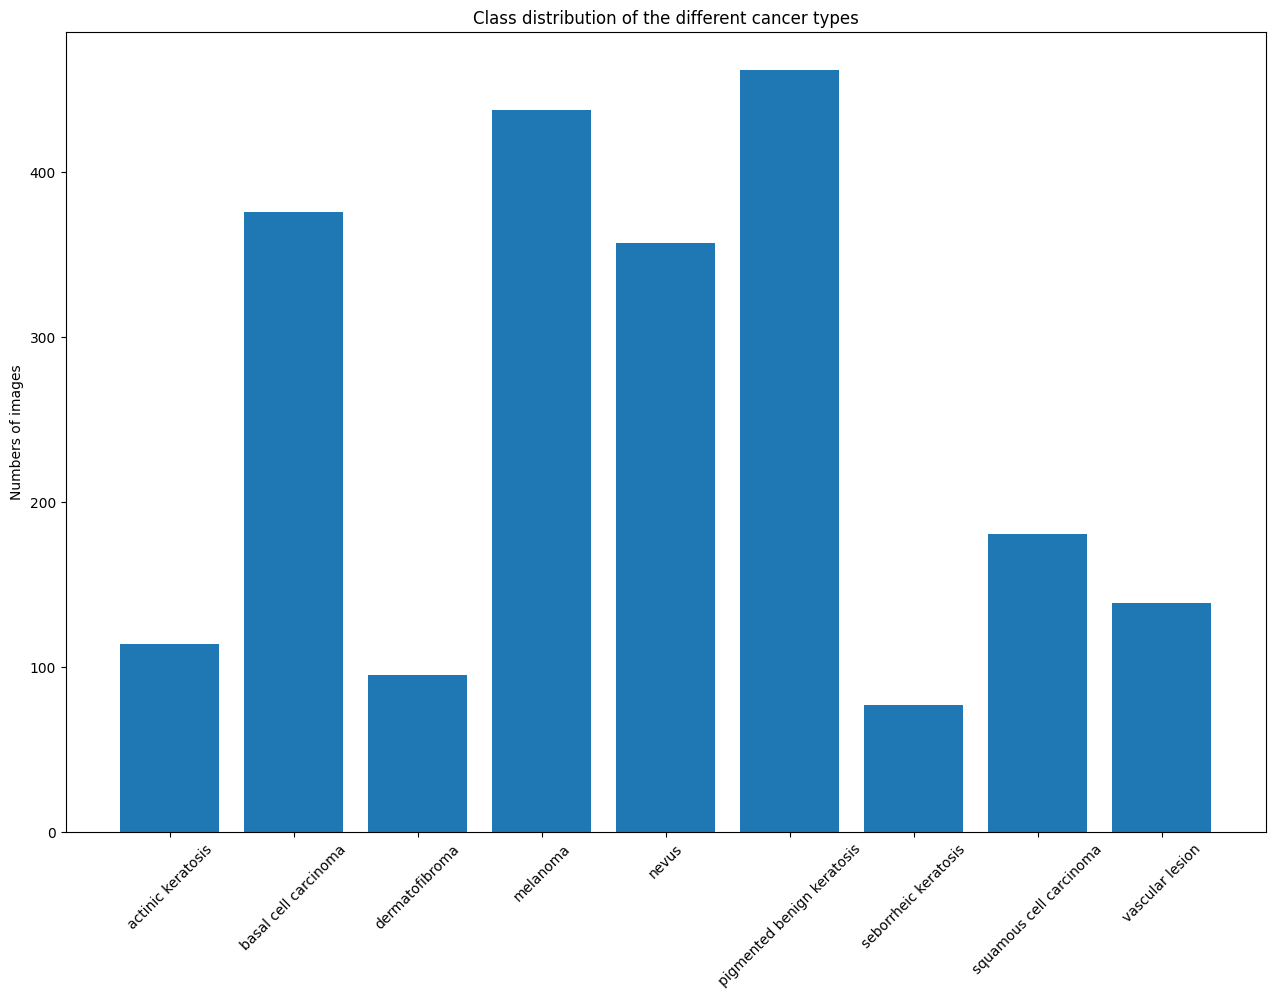

In [28]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
path_list=[]
lesion_list=[]
for i in range(len(class_names)):
  path_list.append(class_names[i])
  lesion_list.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(path_list,lesion_list)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [29]:
### Print the number of samples in each class
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### **Todo:** Write your findings here:

#### Observation
##### There is a huge class imbalance as per the data above.

#### - Which class has the least number of samples?
##### Answer:- seborrheic keratosis : Number of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
##### Answer:- pigmented benign keratosis : Number of samples - 462



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset= "/content/drive/MyDrive/upgrad/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E68092B0400>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6809151ED0>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6806DD7670>: 100%|██████████| 500/500 [00:25<00:00, 19.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7E6814127A30>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E688822AB30>: 100%|██████████| 500/500 [01:02<00:00,  8.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6806DD7670>: 100%|██████████| 500/500 [00:19<00:00, 25.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E6809152230>: 100%|██████████| 500/500 [00:43<00:00, 11.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E68092B0580>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/upgrad/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6806DD74F0>: 100%|██████████| 500/500 [00:20<00:00, 24.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010741.jpg_d8ad127c-30b3-4936-acae-50a25be26115.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010789.jpg_a8544801-ab40-4269-91f5-4a92a9dea83a.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010971.jpg_4d0e8954-bc8b-4bef-90d8-23ab5399c253.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010971.jpg_f036b582-c93f-4abf-bc42-3f674d77bca1.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_d90511d8-98a5-4586-ab3e-964185d19a58.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010977.jpg_99146fa7-92c6-4a20-840e-d0910034aa8e.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC_0010482.jpg_1b5de2cf-1290-4811-8cf3-f41c34e152d7.jpg',
 '/content/drive/MyDrive/upgrad/Train/melanoma/output/melanoma_original_ISIC

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [39]:
new_df['Label'].value_counts()

Label
melanoma                      500
dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
actinic keratosis             500
nevus                         500
pigmented benign keratosis    500
basal cell carcinoma          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train="/content/drive/MyDrive/upgrad/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
# CNN Model using data created by Augmentor
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [46]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

#### **Todo:**  Train your model

In [48]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 11s 67ms/step - loss: 0.1247 - accuracy: 0.9451 - val_loss: 0.6954 - val_accuracy: 0.8352
Epoch 2/50
169/169 [==============================] - 11s 64ms/step - loss: 0.1374 - accuracy: 0.9436 - val_loss: 0.7291 - val_accuracy: 0.8537
Epoch 3/50
169/169 [==============================] - 9s 55ms/step - loss: 0.1190 - accuracy: 0.9518 - val_loss: 0.7261 - val_accuracy: 0.8664
Epoch 4/50
169/169 [==============================] - 9s 56ms/step - loss: 0.1279 - accuracy: 0.9468 - val_loss: 0.8088 - val_accuracy: 0.8486
Epoch 5/50
169/169 [==============================] - 9s 56ms/step - loss: 0.1248 - accuracy: 0.9468 - val_loss: 0.9952 - val_accuracy: 0.8129
Epoch 6/50
169/169 [==============================] - 9s 55ms/step - loss: 0.1240 - accuracy: 0.9466 - val_loss: 0.7128 - val_accuracy: 0.8530
Epoch 7/50
169/169 [==============================] - 9s 56ms/step - loss: 0.1153 - accuracy: 0.9522 - val_loss: 0.7806 - val_accuracy: 0.86

#### **Todo:**  Visualize the model results

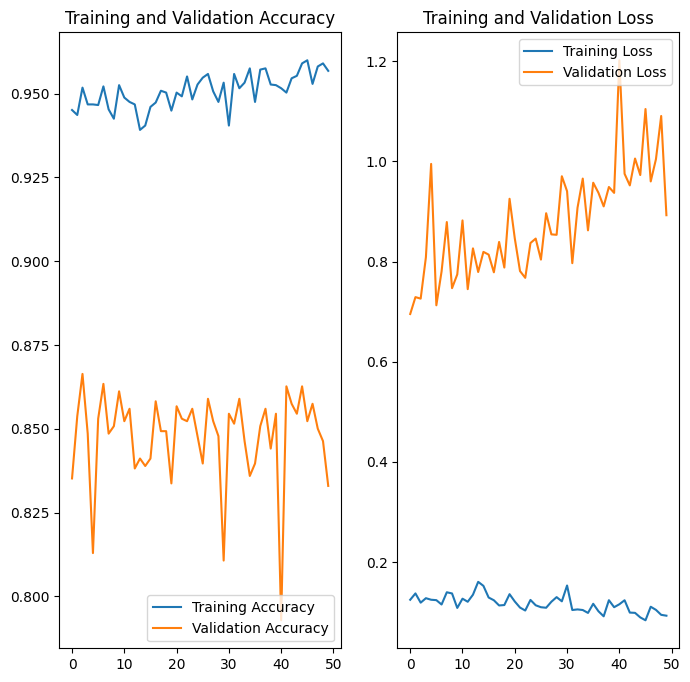

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [50]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Loss: ",loss)
print("Validation Accuracy: ",accuracy_v)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 12ms/step - loss: 0.8927 - accuracy: 0.8330
Accuracy:  0.966431736946106
Loss:  0.06977846473455429
Validation Accuracy:  0.832962155342102
Validation Loss 0.8927416205406189


#### Observation


1.   After class rebalancing, validation accuracy has improved.
2.   After class rebalancing, training accuracy has also improved slightly and is nearly 96.6%
3.   There is still some gap between validation loss and training loss.
4.   The problem of overfitting has also reduced as the gap between valiation loss and training loss has reduced. The gap between training and validation accuracy has also come down significantly.





